In [6]:
# %%
# --- セル 1: 必要なライブラリのインポート ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path
from tqdm import tqdm
from typing import List, Dict, Iterable, Tuple, Optional

# %%
# --- セル 2: config 変数の定義 ---
# (src.config からのインポートが機能しない場合、ここで直接定義する)
try:
    import _init_notebook
    from src.config import (
        PROCESSED_DIR, TMIN, TMAX, BASELINE, SAMPLING_RATE,
        EEG_CHANNELS_TO_FILTER, EVENT_RANGES, N_JOBS
    )
except ImportError:
    print("src.config を読み込めないため、変数を仮設定します。")


# %%
# --- セル 3: ERP計算関数の定義 (src/erp_utils.py の内容) ---
def calculate_erp(
    df: pd.DataFrame,
    event_ids: Iterable[int],
    channels: List[str],
    tmin_sec: float,
    tmax_sec: float,
    baseline_sec: Tuple[float, float],
    sampling_rate: int
) -> Dict[str, np.ndarray]:
    
    tmin_samples = int(tmin_sec * sampling_rate)
    tmax_samples = int(tmax_sec * sampling_rate)
    total_samples = tmax_samples - tmin_samples
    
    baseline_start_idx = int(baseline_sec[0] * sampling_rate) - tmin_samples
    baseline_end_idx = int(baseline_sec[1] * sampling_rate) - tmin_samples
    baseline_indices = np.arange(baseline_start_idx, baseline_end_idx)

    epochs_dict = {ch: [] for ch in channels}
    
    valid_event_mask = df['Event_ID'].isin(event_ids)
    onset_indices = df.index[valid_event_mask & (df['Event_ID'].diff() != 0)]

    for stim_onset_idx in onset_indices:
        start_cut_idx = stim_onset_idx + tmin_samples
        end_cut_idx = stim_onset_idx + tmax_samples
        
        if start_cut_idx < 0 or end_cut_idx >= len(df):
            continue
            
        for channel in channels:
            epoch = df[channel].iloc[start_cut_idx:end_cut_idx].values
            
            if len(epoch) == total_samples:
                baseline_value = np.mean(epoch[baseline_indices])
                epoch_corrected = epoch - baseline_value
                epochs_dict[channel].append(epoch_corrected)

    erp_dict = {}
    for channel in channels:
        if epochs_dict[channel]:
            epochs_matrix = np.array(epochs_dict[channel])
            erp_dict[channel] = np.mean(epochs_matrix, axis=0)
        else:
            erp_dict[channel] = np.full(total_samples, np.nan)
            
    return erp_dict

# %%
# --- セル 4: データ集計関数の定義 ---
def aggregate_erp_data():
    processed_path = Path(PROCESSED_DIR)
    files = list(processed_path.glob('*.parquet'))
    if not files:
        files = list(processed_path.glob('*.csv'))
        read_func = pd.read_csv
    else:
        read_func = pd.read_parquet

    if not files:
        print(f"エラー: {PROCESSED_DIR} にファイルが見つかりません。")
        return None

    print(f"{len(files)} 個のファイルを集計します...")
    
    all_erp_data = []
    required_cols = (
        EEG_CHANNELS_TO_FILTER + 
        ['Event_ID', 'Subject_ID', 'Genotype']
    )

    for file_path in tqdm(files, desc="Processing files"):
        try:
            if read_func.__name__ == 'read_parquet':
                df = read_func(file_path, columns=required_cols)
            else:
                df = read_func(file_path, usecols=required_cols)

            if df.empty:
                continue

            subject_id = df['Subject_ID'].iloc[0]
            genotype = df['Genotype'].iloc[0]
            
            for stim_name, (start_id, end_id) in EVENT_RANGES.items():
                event_ids = range(start_id, end_id + 1)
                
                erp_dict = calculate_erp(
                    df, event_ids, EEG_CHANNELS_TO_FILTER,
                    TMIN, TMAX, BASELINE, SAMPLING_RATE
                )
                
                for channel, erp_wave in erp_dict.items():
                    if np.isnan(erp_wave).all():
                        continue
                        
                    for i, amplitude in enumerate(erp_wave):
                        time_sec = TMIN + (i / SAMPLING_RATE)
                        all_erp_data.append({
                            'Subject_ID': subject_id,
                            'Genotype': genotype,
                            'Stimulus': stim_name,
                            'Channel': channel.replace('_filtered', ''),
                            'Time': time_sec,
                            'Amplitude': amplitude
                        })
            del df
        except Exception as e:
            print(f"エラー処理中 {file_path.name}: {e}")

    if not all_erp_data:
        return None
    return pd.DataFrame(all_erp_data)

In [13]:
# %%
# --- セル 5: 可視化関数の定義 (チャンネル配色、Y軸固定 版) ---
def plot_grouped_erp_individual_traces(erp_df, show_individual=True):
    """
    集計されたDataFrameを使い、グループERPと個体ERPをプロットする。
    ・チャンネルごとに色分け (PFC:青系, PPC:橙系, A1:緑系, V1:赤系)
    ・Genotypeごとに明暗 (WT:濃, Het:淡)
    ・Y軸を ±40 で固定
    ・N数表示、チャンネル順序固定
    """
    if erp_df is None or erp_df.empty:
        print("プロットするデータがありません。")
        return

    print("プロットを生成中...")
    STIM_DURATION_SEC = 0.5 
    
    # ★変更点1: チャンネルの順序を固定
    channels_for_display = ['PFC', 'PPC', 'A1', 'V1']
    
    stimuli_order = list(EVENT_RANGES.keys()) 
    for s in erp_df['Stimulus'].unique():
        if s not in stimuli_order:
            stimuli_order.append(s)

    genotype_order = ['WT', 'Het'] 

    for stim_name in stimuli_order:
        stim_df = erp_df[erp_df['Stimulus'] == stim_name]
        
        if stim_df.empty:
            print(f"Warning: 刺激 '{stim_name}' のデータが見つかりません。")
            continue
            
        # N数を計算し、凡例用のラベルを作成
        n_counts = stim_df.groupby('Genotype')['Subject_ID'].nunique().to_dict()
        genotype_n_map = {g: f"{g} (n={n_counts.get(g, 0)})" for g in genotype_order}
        
        stim_df_copy = stim_df.copy()
        stim_df_copy.loc[:, 'Genotype_N'] = stim_df_copy['Genotype'].map(genotype_n_map)
        
        hue_order_with_n = [genotype_n_map[g] for g in genotype_order]

        # ★変更点2: チャンネルごとの配色(濃淡)マップをここで定義
        # N数のラベル (例: "WT (n=10)") に対応する色を動的に設定
        palette_map = {
            'PFC': {genotype_n_map['WT']: '#1f77b4', genotype_n_map['Het']: '#aec7e8'}, # 青系 (濃/淡)
            'PPC': {genotype_n_map['WT']: '#ff7f0e', genotype_n_map['Het']: '#ffbb78'}, # 橙系 (濃/淡)
            'A1':  {genotype_n_map['WT']: '#2ca02c', genotype_n_map['Het']: '#98df8a'}, # 緑系 (濃/淡)
            'V1':  {genotype_n_map['WT']: '#d62728', genotype_n_map['Het']: '#ff9896'}  # 赤系 (濃/淡)
        }
        # 個体波形用の薄い色マップ
        individual_palette_map = {
            'PFC': {genotype_n_map['WT']: '#1f77b4', genotype_n_map['Het']: '#aec7e8'},
            'PPC': {genotype_n_map['WT']: '#ff7f0e', genotype_n_map['Het']: '#ffbb78'},
            'A1':  {genotype_n_map['WT']: '#2ca02c', genotype_n_map['Het']: '#98df8a'},
            'V1':  {genotype_n_map['WT']: '#d62728', genotype_n_map['Het']: '#ff9896'}
        }


        fig, axes = plt.subplots(
            nrows=len(channels_for_display), 
            ncols=1, 
            figsize=(12, 3 * len(channels_for_display)), 
            sharex=True, 
            sharey=True # Y軸スケールを統一
        )
        
        if len(channels_for_display) == 1:
            axes = [axes]

        fig.suptitle(f'ERP 波形: {stim_name} (個体 & グループ平均)', fontsize=16, y=1.02)

        for i, channel_display_name in enumerate(channels_for_display):
            ax = axes[i]
            
            channel_df = stim_df_copy[stim_df_copy['Channel'] == channel_display_name]
            
            # ★変更点2: 該当チャンネルのパレットを取得
            current_palette_avg = palette_map[channel_display_name]
            current_palette_ind = individual_palette_map[channel_display_name]

            # 個体波形のプロット
            if show_individual:
                sns.lineplot(
                    data=channel_df,
                    x='Time', y='Amplitude',
                    hue='Genotype_N', 
                    hue_order=hue_order_with_n,
                    units='Subject_ID', 
                    estimator=None,
                    lw=0.5, 
                    alpha=0.1, # 個体波形は薄く
                    palette=current_palette_ind, # チャンネルごとの色を適用
                    legend=False, ax=ax, errorbar=None
                )

            # グループ平均波形のプロット
            sns.lineplot(
                data=channel_df,
                x='Time', y='Amplitude',
                hue='Genotype_N', 
                hue_order=hue_order_with_n,
                errorbar='se',
                lw=2, 
                palette=current_palette_avg, # チャンネルごとの色を適用
                ax=ax,
                legend='full' if i == 0 else False
            )
            
            ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
            ax.axvline(x=STIM_DURATION_SEC, color='blue', linestyle='--', linewidth=1)
            
            ax.set_ylabel(f'{channel_display_name}\n振幅 (μV?)')
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_xlabel('')
            
            # ★変更点3: Y軸のスケールを固定
            ax.set_ylim(-40, 50)
            ax.set_xlim(-0.125, 1.125)
            
            if i == 0:
                ax.legend(title='Genotype', loc='upper right', bbox_to_anchor=(1.25, 1))

        axes[-1].set_xlabel('刺激開始からの時間 (秒)')
        
        fig.tight_layout(rect=[0, 0, 0.95, 0.98])
        plt.show()

In [6]:
# %%
# --- セル 6 (修正版): 集計とファイル保存 ---
aggregated_df = aggregate_erp_data()

if aggregated_df is not None:
    # analysis_results フォルダを作成
    output_dir = Path(PROCESSED_DIR).parent / "analysis_results"
    output_dir.mkdir(exist_ok=True)
    save_path = output_dir / "aggregated_erp_data.parquet"

    # .parquet 形式で保存
    aggregated_df.to_parquet(save_path)
    print(f"集計データを {save_path} に保存しました。")

    # メモリから削除
    del aggregated_df
else:
    print("集計データがありませんでした。")

16 個のファイルを集計します...


Processing files: 100%|██████████| 16/16 [01:26<00:00,  5.41s/it]


集計データを C:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\data\analysis_results\aggregated_erp_data.parquet に保存しました。


C:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\data\analysis_results\aggregated_erp_data.parquet を読み込んでプロットします。
プロットを生成中...


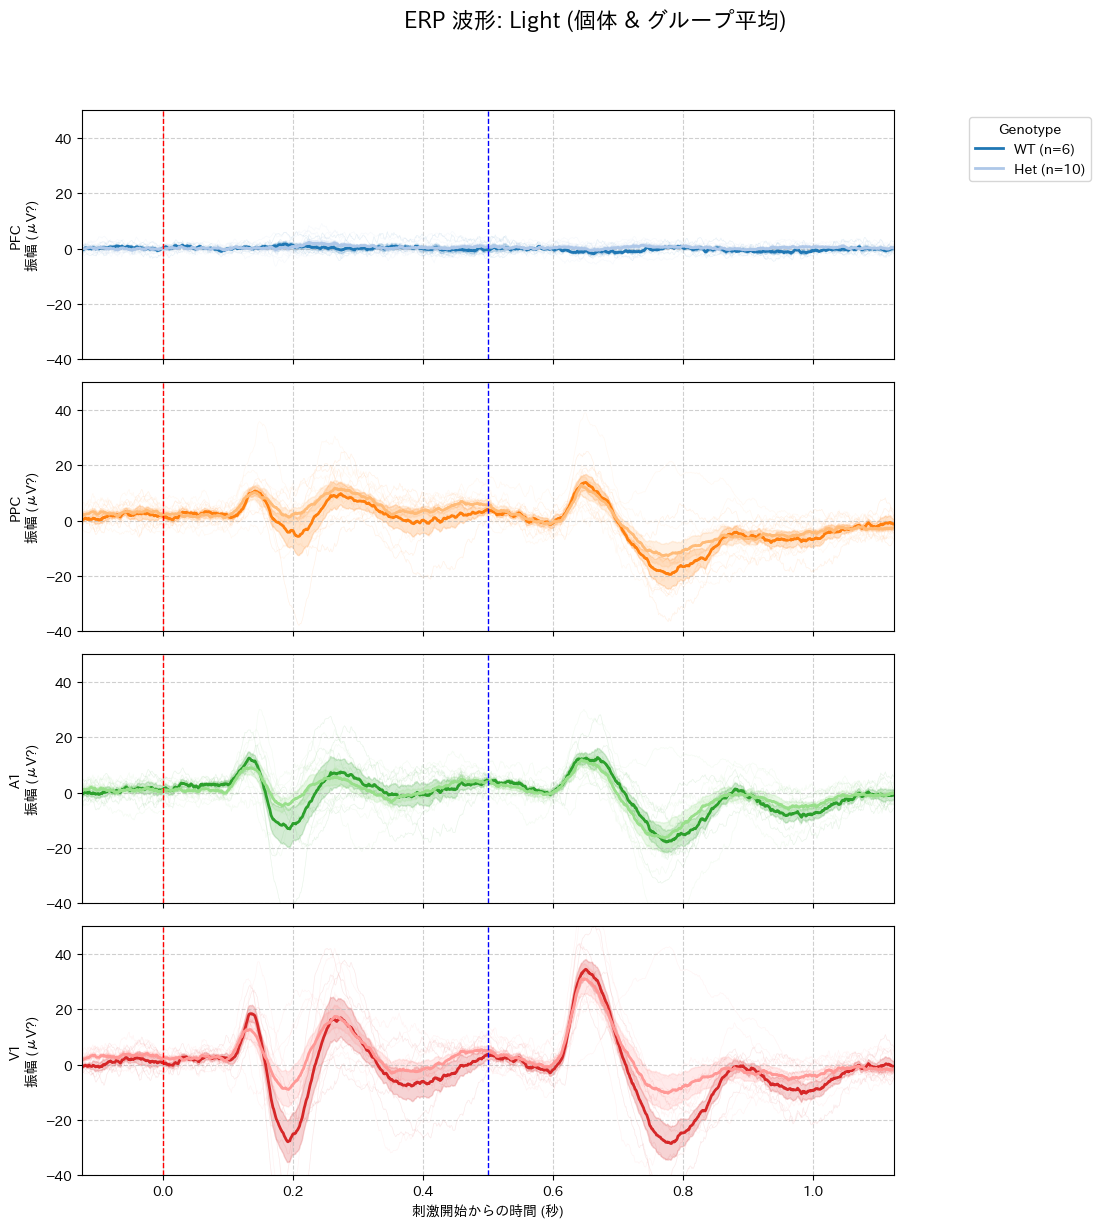

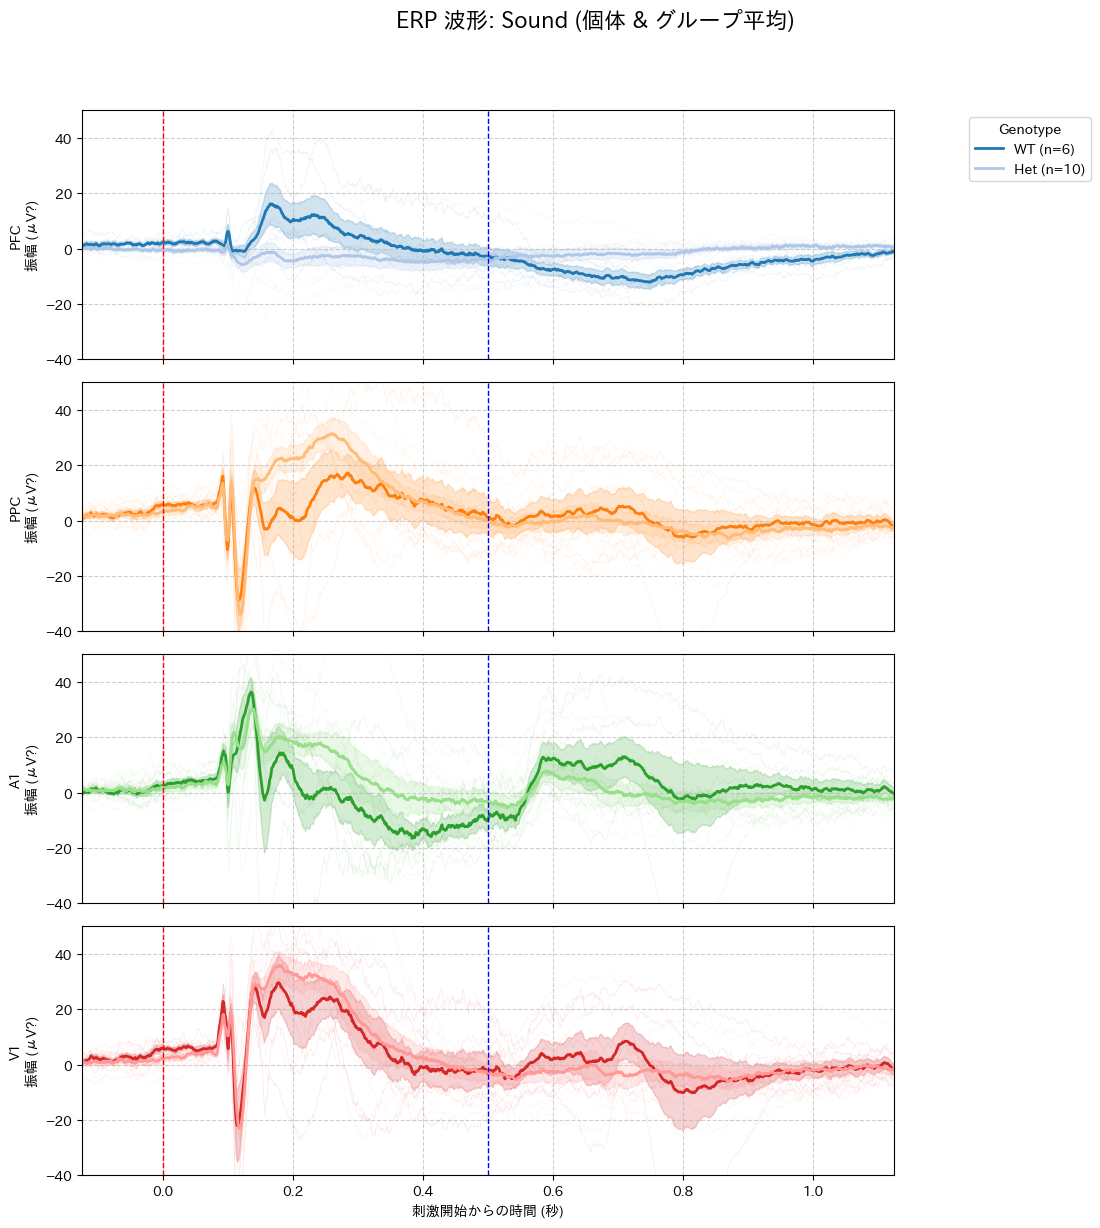

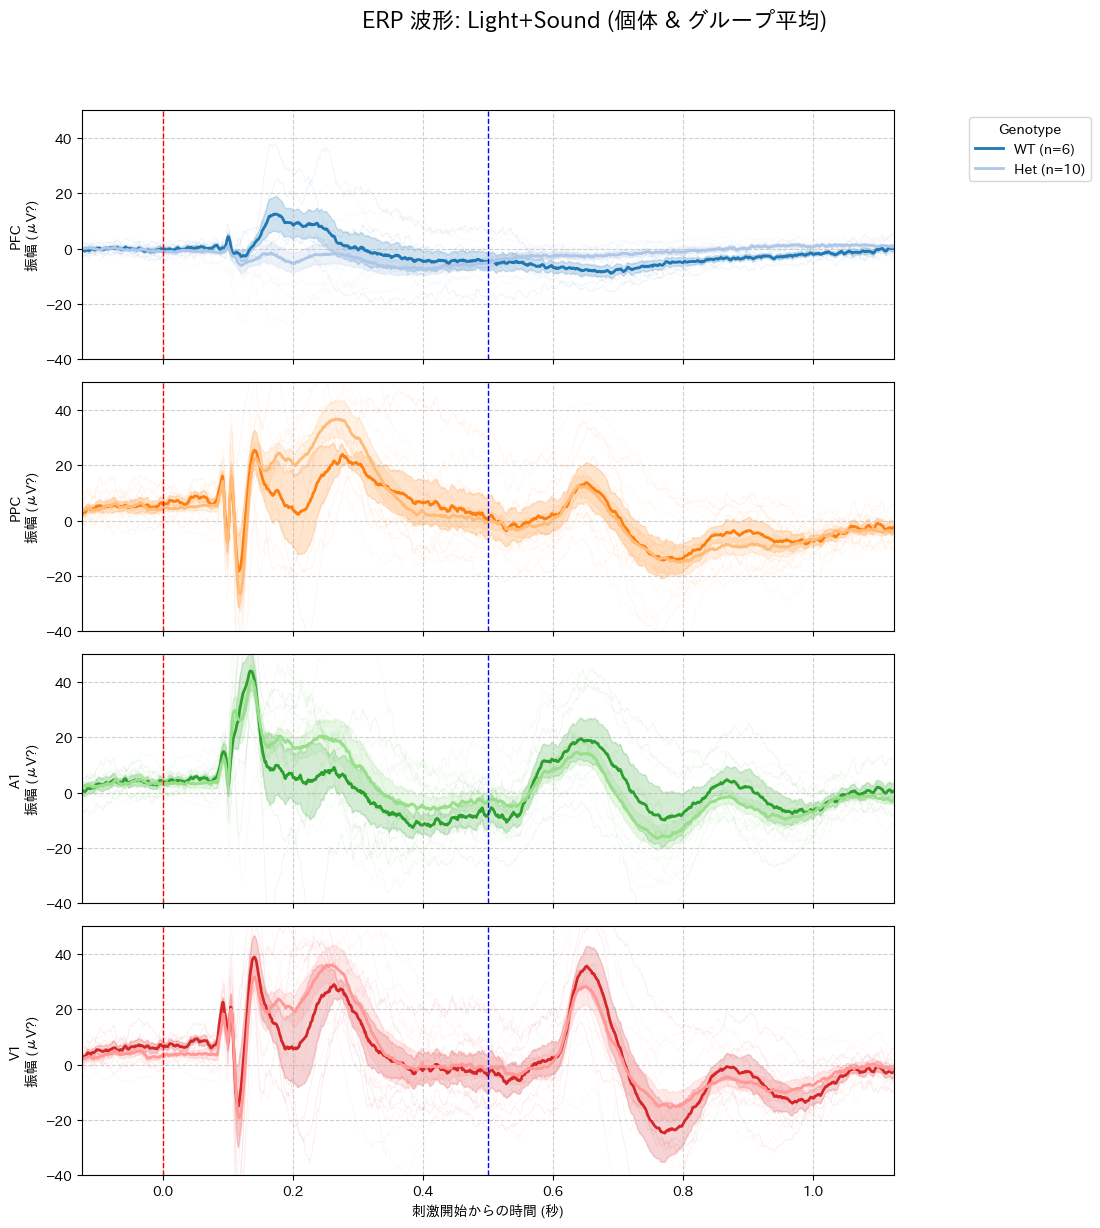

In [14]:
# %%
# --- セル 7 (修正版): 読み込みと可視化 ---
# config 変数を再度読み込む（カーネル再起動のため）
try:
    import _init_notebook
    from src.config import PROCESSED_DIR, EEG_CHANNELS_TO_FILTER
except ImportError:
    PROCESSED_DIR = Path("/mnt/c/Users/dmasu/OneDrive/デスクトップ/pcdh_analyze/data/processed")
    EEG_CHANNELS_TO_FILTER = ['PFC_filtered', 'PPC_filtered', 'A1_filtered', 'V1_filtered']

# 保存したファイルパス
output_dir = Path(PROCESSED_DIR).parent / "analysis_results"
save_path = output_dir / "aggregated_erp_data.parquet"

if save_path.exists():
    print(f"{save_path} を読み込んでプロットします。")
    df_for_plot = pd.read_parquet(save_path)

    # 可視化関数 (plot_grouped_erp) がこのセルより上で定義されている必要あり
    plot_grouped_erp_individual_traces(df_for_plot)
else:
    print(f"エラー: {save_path} が見つかりません。")